In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers

from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix

import rasterio
from rasterio import plot as rastPlt
from rasterio.plot import reshape_as_raster

# Data preparation
### Fetch data from file

In [5]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathSatellite = folderName + "Landsat-8.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=0, area=aoi)

print('Tiles:',dataCoords.shape[0])


Tiles: 139113


In [6]:
# Fetch images
lightMask = dataRadiance>1
idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[dataRadiance==1],500, replace=False)
darkData = dataCoords[idxDarkData]
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, np.concatenate((dataCoords[lightMask], darkData)), True)
trainData = utils.formatData(trainData, res=64, toFloat=True)
print('Light Tile:',len(trainData)-len(darkData))
print('dark Tile:',len(darkData))
print('Total train',trainData.shape)

train = trainData
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[idxDarkData])).astype("float32") / 255

Light Tile: 1472
dark Tile: 500
Total train (1972, 64, 64, 3)


## CNN

In [7]:
# Input encoder
input_shape = keras.Input(shape=trainData.shape[1:])

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(1, activation='sigmoid')(cnn)

modelCNN = keras.Model(input_shape, cnn)
modelCNN.compile(optimizer=optimizer, loss=lossFunction)

result = modelCNN.fit(
  x=train[::2],
  y=validation[::2],
  epochs=20,
  batch_size=10,
  shuffle=True,
  verbose=0,
  validation_data=(train[1::2], validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 6,113
Trainable params: 6,113
Non-trainable par

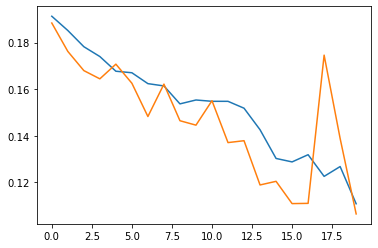

In [8]:
matPlt.plot(result.history['loss'][:], label='Training')
matPlt.plot(result.history['val_loss'][:], label='test')
modelCNN.summary()

In [9]:
testCoordsData = dataCoords[::]
#testCoordsData = dataCoords

print('Process validation...')
getValid = lambda data : [ int(any([ any(c > 250 for c in row) for row in img[0] ])) for img in data ]
resultValid = utils.scanSatellite(pathValidation, testCoordsData, getValid, batch=1000)

Process validation...


In [10]:
print('Process score...')
getScore = lambda data : modelCNN.predict(utils.formatData(data, res=64, toFloat=True), verbose=0)
result = utils.scanSatellite(pathSatellite, testCoordsData, getScore, batch=1000)

Process score...


In [11]:
print('Process confustion matrix...')
print(len(result))
resultTest = (np.asarray(result) > 0.5).astype(int)
confusionMatrix = confusion_matrix(resultValid, resultTest)
print(confusionMatrix)
#print((confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0] + confusionMatrix[1][1]),"%")
print((confusionMatrix[1][1]) / (confusionMatrix[0][1] + confusionMatrix[1][1]),"%")

Process confustion matrix...
139113
[[109874   6575]
 [ 20786   1878]]
0.22216964391340352 %


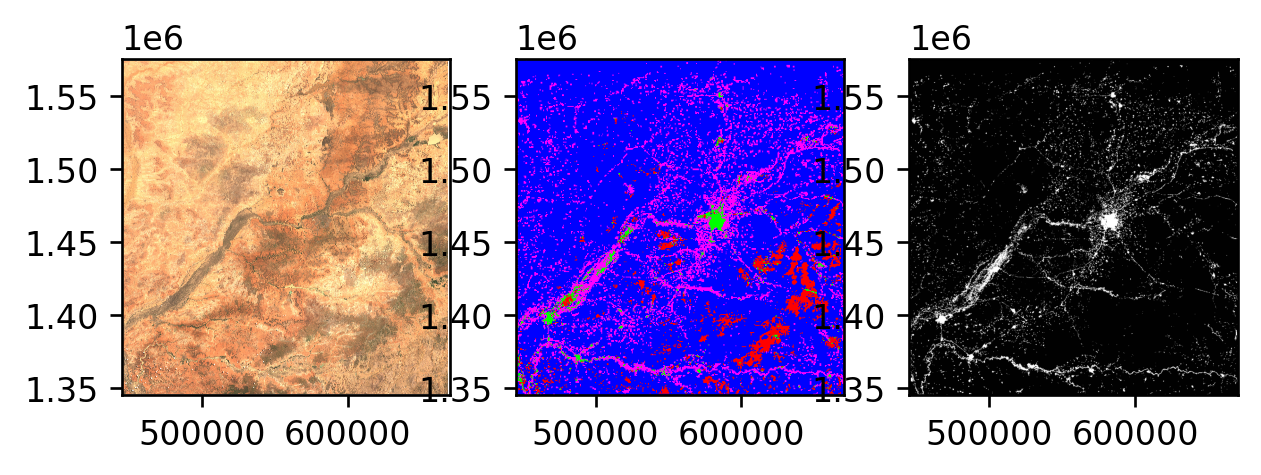

In [12]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, testCoordsData, resultTest, resultValid)

fig, axs = matPlt.subplots(1,3, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

with rasterio.open(pathValidation) as p: rastPlt.show(p, ax=axs[2])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])

In [13]:
img = np.copy(resultImg)
#img[1,:,:] = 150
img = img[0:3,:,:]
img = img.transpose([1, 2, 0])
with rasterio.open(pathNight) as f:
  profile = f.profile
img = reshape_as_raster(img)
profile.update(count=3)
print(profile)
print(img.shape)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 768, 'height': 768, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(611.4962262814099, 0.0, 312780.31974294124,
       0.0, -611.4962262814088, 1722279.1213215904), 'tiled': False, 'interleave': 'pixel'}
(3, 768, 768)


In [ ]:
with rasterio.open(folderName + 'example2.tif', 'w', **profile) as f:
  f.write(img)


In [ ]:
print(resultImg[:,301,340])